# First look

* [Priority Population/DAC](https://dot.ca.gov/programs/rail-and-mass-transportation/priority-populations-and-disadvantaged-communities)

In [1]:
import numpy as np
import pandas as pd
from calitp_data_analysis import geography_utils, utils
from calitp_data_analysis.sql import to_snakecase
import os

# Formatting the nb
pd.options.display.max_columns = 100
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

# Scripts
import A1_data_prep as data_prep

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Loading in the script

In [2]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/lctop/"
FILE_NAME = "LCTOP_allyears.xlsx"

In [3]:
#Original df 
df1 = to_snakecase(
    pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="LCTOP_Projects")
)

In [4]:
#Cleaned df
df2 = data_prep.clean_lctop()

/home/jovyan/data-analyses/lctop/A1_data_prep.py:70: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[col_of_int] = (dataframe[col_of_int]


In [5]:
district_summary, gdf_dist = data_prep.district_fy_summary()

/home/jovyan/data-analyses/lctop/A1_data_prep.py:70: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[col_of_int] = (dataframe[col_of_int]
/home/jovyan/data-analyses/lctop/A1_data_prep.py:87: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[_]", " ").str.title().str.strip()


In [6]:
#df2['lead_agency'].sort_values().unique()

In [7]:
df2['lead_agency'].nunique()

175

## Checking out the raw data

In [8]:
df1.shape

(857, 74)

In [9]:
# Get percentages of how many null values per column
df1.isnull().sum() * 100 / len(df1)

count                                               0.700117
#                                                   0.700117
funding_year                                        0.700117
_d                                                  0.700117
distr_                                              0.700117
project_id#                                         0.700117
lead_agency                                         0.700117
project_name                                        0.700117
project_type                                        0.583431
project_sub_type                                   27.421237
project_sub_type_ii                                 0.700117
#2                                                 99.533256
project_description__short_                        11.785298
project_location                                   28.121354
start_date                                         12.018670
completion_date                                    27.304551
contact_name            

In [10]:
# Check out that values are what I expect for certain columns
value_count_cols = [
    "project_type",
    "lead_agency",
    "distr_",
    "project_name",
    "project_id#",
    "project_sub_type_ii",
]

In [11]:
# https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe
"""
for column in df1[value_count_cols]:
    print("\n" + column)
    print(df1[column].value_counts())
    
"""

'\nfor column in df1[value_count_cols]:\n    print("\n" + column)\n    print(df1[column].value_counts())\n    \n'

In [12]:
# Find nunique values
for column in df1[value_count_cols]:
    print("\n" + column)
    print(df1[column].nunique())


project_type
3

lead_agency
213

distr_
12

project_name
714

project_id#
851

project_sub_type_ii
12


### Double checking monetary columns


In [13]:
monetary_cols = [
    "puc_99313_funds",
    "puc_99314_funds",
    "total_project_request_99314_+_99313",
    "total_lctop_funds",
    "total_cci_funds",
    "total_project_cost",
    "lctop_%_of_total_project_funds",
]

In [14]:
subset = df1[monetary_cols].fillna(0)

In [15]:
# https://stackoverflow.com/questions/42405572/how-to-compare-two-columns-of-the-same-dataframe
# Compare if PUC 99313 + PUC 99314 equal to total LCTOP Fund
subset["total_project_comp_to_total_LCTOP_funds"] = np.where(
    subset["total_project_request_99314_+_99313"] == subset["total_lctop_funds"],
    "same",
    "different",
)

In [16]:
# Comapre if LCTOP equals CCI
subset["total_lctop_cci"] = np.where(
    subset["total_lctop_funds"] == subset["total_cci_funds"], "same", "different"
)

In [17]:
# Calculate out total_project_request_99314_+_99313 and see if the results equal what was provided to me.
subset["99314_and_99313"] = subset["puc_99313_funds"] + subset["puc_99314_funds"]
subset["my_calc_vs_og_cal"] = np.where(
    subset["99314_and_99313"] == subset["total_project_request_99314_+_99313"],
    "same",
    "different",
)

In [18]:
# Compare total_project_request_99314_+_99313 with total CCI funds
subset["CCI_99313_99314"] = np.where(
    subset["total_project_request_99314_+_99313"] == subset["total_cci_funds"],
    "same",
    "different",
)

In [19]:
# Find value_counts
value_count_cols_2 = [
    "total_project_comp_to_total_LCTOP_funds",
    "total_lctop_cci",
    "my_calc_vs_og_cal",
    "CCI_99313_99314",
]
for column in subset[value_count_cols_2]:
    print("\n" + column)
    print(subset[column].value_counts())


total_project_comp_to_total_LCTOP_funds
different    435
same         422
Name: total_project_comp_to_total_LCTOP_funds, dtype: int64

total_lctop_cci
same         813
different     44
Name: total_lctop_cci, dtype: int64

my_calc_vs_og_cal
same         856
different      1
Name: my_calc_vs_og_cal, dtype: int64

CCI_99313_99314
different    446
same         411
Name: CCI_99313_99314, dtype: int64


In [20]:
# subset.loc[subset['my_calc_vs_og_cal'] == 'different']

### Other Cleaning Steps
* Double check that agencies are only spelled in ONE way, not in multiple ways.
* Change any yes/no open/close columns to lower and strip spaces, so there aren't diffrent options.
* Removed county.
* Make sure all cols are the same data type

In [21]:
#Check values manually 
#df2['lead_agency'].sort_values().unique()

## Initial insights

### How are projects benefitting DAC, are they finished or in progress, how many null values are present, etc?
* [Disadvantaged Communities](https://dot.ca.gov/programs/rail-and-mass-transportation/priority-populations-and-disadvantaged-communities)
* Most projects benefit DAC.
* Most agencies have a service area with DAC.

In [22]:
# count
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
result = {}
for i in df2[data_prep.boolean_cols]:
    result[i] = df2[i].value_counts()

In [23]:
result_df = (
    pd.DataFrame.from_dict(result).fillna(0).rename(columns={"index": "Boolean Values"})
)

result_df = result_df.div(result_df.sum(axis=0), axis=1)

In [24]:
result_df.round(2).style.background_gradient()

,agency_service_area_has_a_dac,does_project_benefit_an_ab_1550_dac,status,qualifying_1_2_mile_low_income_buffer_,ab_1550_low_income_community__household
0,0.000000,0.000000,0.000000,0.180000,0.000000
1,0.000000,0.000000,0.000000,0.190000,0.000000
None,0.000000,0.000000,0.370000,0.480000,0.410000
closed,0.000000,0.000000,0.020000,0.000000,0.000000
no,0.300000,0.340000,0.000000,0.150000,0.050000
open,0.000000,0.000000,0.610000,0.000000,0.000000
yes,0.700000,0.660000,0.000000,0.000000,0.540000


### Summary Tables

In [25]:
sum_cols = [
    "funds_to_benefit_dac",
    "total_project_request_99314_+_99313",
    "total_project_cost",
    "vmt_reduction",
    "ghg_reduction__mtco2e_",
    "diesel_pm_reductions__lbs_",
    "nox_reductions__lbs_",
    "pm_2_5_reductions__lbs_",
    "reactive_organic_gas_reduction__lbs_",
    "fossil_fuel_use_reduction__transportation_",
    "ridership_increase",
    "fossil_fuel_use_reduction__energy_",
    "renewable_energy_generation__kwh_",
]
nunique_cols = ["project_id#", "lead_agency"]

In [26]:
funding_year_summary = geography_utils.aggregate_by_geography(
    df2, group_cols=["funding_year"], nunique_cols=nunique_cols, sum_cols=sum_cols
)

funding_year_summary = (
    data_prep.cols_cleanup(funding_year_summary)
    .sort_values("Funding Year")
    .rename(columns={"Lead Agency": "# of Agencies", "Project Id#": "# of Projects"})
)

/home/jovyan/data-analyses/lctop/A1_data_prep.py:87: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[_]", " ").str.title().str.strip()


In [27]:
funding_year_summary

,Funding Year,Diesel Pm Reductions Lbs,Fossil Fuel Use Reduction Energy,Fossil Fuel Use Reduction Transportation,Funds To Benefit Dac,Ghg Reduction Mtco2E,Nox Reductions Lbs,Pm 2 5 Reductions Lbs,Reactive Organic Gas Reduction Lbs,Renewable Energy Generation Kwh,Ridership Increase,Total Project Cost,Total Project Request 99314 + 99313,Vmt Reduction,# of Agencies,# of Projects
0,14-15,0.000000e+00,0.000000e+00,0.000000e+00,22753617.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,24165593.0,0.000000e+00,83,95
1,15-16,0.000000e+00,0.000000e+00,0.000000e+00,69453304.00,1.073481e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.368380e+05,5.328010e+08,74700760.0,1.193036e+06,107,132
2,16-17,0.000000e+00,0.000000e+00,0.000000e+00,29652105.00,4.161658e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.265336e+08,2.625839e+09,34539105.0,1.018104e+10,105,126
3,17-18,7.274582e+04,3.110295e+06,0.000000e+00,66033836.71,3.615715e+06,1.796139e+07,6.073385e+05,1.143040e+06,0.0,1.728538e+09,2.526653e+09,96864564.5,7.682500e+09,109,152
4,18-19,3.431726e+05,0.000000e+00,7.416759e+07,91638903.30,3.062603e+06,1.141796e+07,4.694226e+05,1.476528e+06,0.0,7.098338e+08,4.137513e+09,146949406.0,4.593430e+09,120,180
5,19-20,1.428119e+06,-5.766985e+08,8.623977e+07,79344810.00,2.431934e+06,1.155675e+07,1.408619e+06,4.032265e+06,3360000.0,2.058798e+08,2.889874e+09,146054354.0,3.096126e+09,110,166


In [28]:
project_type_summary = geography_utils.aggregate_by_geography(
    df2,
    group_cols=["project_sub_type_ii"],
    nunique_cols=nunique_cols,
    sum_cols=sum_cols,
)

project_type_summary = (
    data_prep.cols_cleanup(project_type_summary)
    .sort_values("Lead Agency")
    .rename(columns={"Lead Agency": "# of Agencies", "Project Id#": "# of Projects"})
)

/home/jovyan/data-analyses/lctop/A1_data_prep.py:87: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[_]", " ").str.title().str.strip()


In [29]:
project_type_summary['# of Projects'].sum()

851

In [30]:
project_type_summary['Funds To Benefit Dac'].sum()

358876576.01

In [31]:
district_summary['Funds To Benefit Dac'].sum()

358876576.01

In [32]:
district_summary['# of Projects'].sum()

851

## Lat Lon

* https://geopandas.org/en/stable/docs/user_guide/mapping.html

In [33]:
# Get only values w/ lon and lat
df3 = df2.loc[df2["project_location"] != "None"]

In [34]:
#Some rows have tons of coordinates such as 37.37364, -118.39187; 37.41964, -118.55522; 37.5613, -118.6812; 37.56543, -118.74272; 37.63860, -118.96520
#keep only first one.
df3["project_location_2"] = df1["project_location"].str.split(";").str[0]

/tmp/ipykernel_1238/753434518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["project_location_2"] = df1["project_location"].str.split(";").str[0]


In [35]:
df3[["lat","lon"]] = (
    df3["project_location_2"]
    .str.split(",", 1, expand=True)
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .astype('float')
)

/tmp/ipykernel_1238/2233626924.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df3["project_location_2"]
/tmp/ipykernel_1238/2233626924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[["lat","lon"]] = (
/tmp/ipykernel_1238/2233626924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[["lat","lon"]] = (


In [36]:
#Only get values that are populated
df3 = df3[(df3["lon"] != 0) & (df3["lat"] != 0)]
len(df3)

371

In [37]:
df3[['project_location','project_location_2','lon','lat']].sample(5)

,project_location,project_location_2,lon,lat
734,"37.659041, -122.405117;","37.659041, -122.405117",-122.405117,37.659041
625,"33.904747, -118.311141; 33.895968, -118.220382; 33.832123, -118.308886","33.904747, -118.311141",-118.311141,33.904747
281,"38.581871, -121.50166","38.581871, -121.50166",-121.501660,38.581871
707,"38.665422, -121.508533;","38.665422, -121.508533",-121.508533,38.665422
716,"39.149815, -121.596269;","39.149815, -121.596269",-121.596269,39.149815


In [38]:
gdf1 = geography_utils.create_point_geometry(df3, 'lon', 'lat')

In [39]:
type(gdf1)

geopandas.geodataframe.GeoDataFrame

In [40]:
gdf1.lat.min(), gdf1.lat.max()

(-121.4860583, 41.909209)

In [41]:
gdf1.lon.min(), gdf1.lon.max()

(-117926838.0, 119.573668)

In [42]:
#Replace the longtitude manually that is out of bounds 
#Didn't work.
#gdf1.loc[(gdf1["project_id#"] == "18-19-D12-181"), "lon"] = -117.923638

In [43]:
gdf1 = gdf1.loc[gdf1["lon"] > -180]

In [44]:
gdf1.shape

(370, 63)

In [45]:
gdf1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

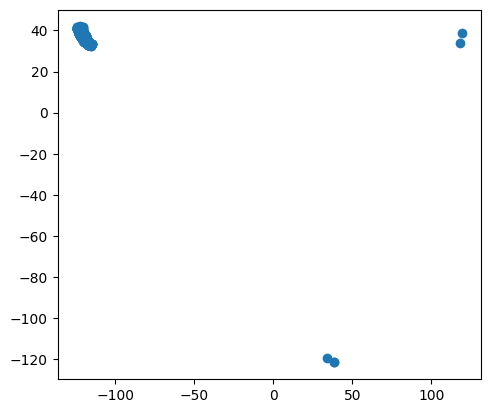

In [46]:
gdf1[['geometry']].plot()

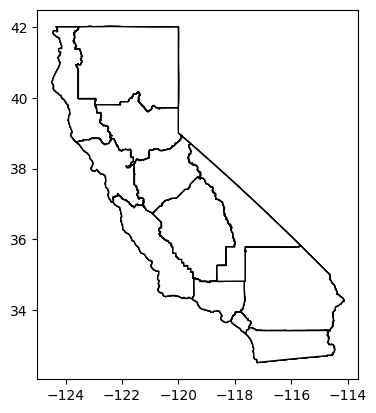

In [47]:
base = gdf_dist.plot(color='white', edgecolor='black')

In [48]:
gdf1 = gdf1.to_crs(gdf_dist.crs)

In [49]:
gdf1.plot(ax=base,  color='red', markersize=5);

<Figure size 640x480 with 0 Axes>